# Ensemble Model for Crypto Price Prediction

**Target**: Predicting whether the crypto price will be higher in 5 days than it is today  
**Method**: Ensemble - Combining Multiple Models' Predictions

## What is an Ensemble?
- **Combines Multiple Models**: Uses ANN, GRU, LSTM, and Transformer together
- **Wisdom of the Crowd**: Different models make different mistakes
- **Better Accuracy**: Averaging reduces individual model errors
- **More Robust**: Less likely to overfit than any single model
- **Simple Method**: Just average the predictions!

## Ensemble vs Single Models:
| Feature | Single Model | Ensemble |
|---------|--------------|----------|
| **Training** | One model | Multiple models |
| **Predictions** | One prediction | Average of predictions |
| **Accuracy** | Good | Usually better |
| **Robustness** | Can overfit | More stable |
| **Speed** | Fast | Slower (4x predictions) |

## How Ensemble Works:
1. Train 4 different models (ANN, GRU, LSTM, Transformer)
2. Get prediction from each model
3. Average the 4 predictions
4. Use the average as final prediction

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

# Random seeds for reproducibility
SEED = 101
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load data
df_ensemble = pd.read_csv("/Users/ina/Documents/spicedAcademy/time_series_project/data/final_data/20251115_dataset_crp.csv")

In [3]:
# Train-Validation-Test Split (70%-15%-15% temporal split)
split_date_train = "2024-07-01"
split_date_val = "2024-10-01"
split_date_test = "2025-01-01"

df_train = df_ensemble[df_ensemble['date'] < split_date_train].copy()
df_val = df_ensemble[(df_ensemble['date'] >= split_date_train) & (df_ensemble['date'] < split_date_val)].copy()
df_test = df_ensemble[df_ensemble['date'] >= split_date_test].copy()

print(f"\nTraining set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")


Training set: 142034 samples
Validation set: 9543 samples
Test set: 39328 samples


In [4]:
# Prepare features and targets

# Target columns to exclude
target_columns = [
    'future_5_close_higher_than_today',
    'future_10_close_higher_than_today',
    'future_5_close_lower_than_today',
    'future_10_close_lower_than_today',
    'higher_close_today_vs_future_5_close',
    'higher_close_today_vs_future_10_close',
    'lower_close_today_vs_future_5_close',
    'lower_close_today_vs_future_10_close'
]

# Get feature columns
feature_columns = []
for col in df_train.columns:
    if col not in target_columns:
        feature_columns.append(col)

# Split features and target
X_train = df_train[feature_columns].copy()
y_train = df_train["future_5_close_higher_than_today"].values

X_val = df_val[feature_columns].copy()
y_val = df_val["future_5_close_higher_than_today"].values

X_test = df_test[feature_columns].copy()
y_test = df_test["future_5_close_higher_than_today"].values

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Columns to scale (exclude ticker and date)
columns_to_scale = []
for col in X_train.columns:
    if col not in ['ticker', 'date']:
        columns_to_scale.append(col)

# Fit and transform
X_train_scaled_vals = scaler_X.fit_transform(X_train[columns_to_scale])
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

X_val_scaled_vals = scaler_X.transform(X_val[columns_to_scale])
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled_vals = scaler_X.transform(X_test[columns_to_scale])
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"Features: {X_train_scaled_vals.shape}, Target: {y_train_scaled.shape}")

Features: (142034, 68), Target: (142034,)


In [5]:
# For ANN: use data as-is (no sequences)
X_test_ann = X_test_scaled_vals
y_test_ann = y_test_scaled
test_indices_ann = X_test.index.values

print(f"ANN test shape: {X_test_ann.shape}")

ANN test shape: (39328, 68)


In [6]:
# For GRU/LSTM/Transformer: create sequences
look_back = 20

# Test sequences
X_test_sequences = []
y_test_sequences = []
test_row_indices = []

for crypto in X_test['ticker'].unique():
    is_this_crypto = X_test['ticker'] == crypto
    crypto_features = X_test_scaled_vals[is_this_crypto]
    crypto_targets = y_test_scaled[is_this_crypto]
    crypto_dates = X_test.loc[is_this_crypto, 'date'].values
    crypto_rows = X_test[is_this_crypto].index.values
    
    date_order = np.argsort(crypto_dates)
    crypto_features = crypto_features[date_order]
    crypto_targets = crypto_targets[date_order]
    crypto_rows = crypto_rows[date_order]
    
    num_sequences = len(crypto_features) - look_back
    for i in range(num_sequences):
        sequence = crypto_features[i : i + look_back]
        target = crypto_targets[i + look_back]
        row = crypto_rows[i + look_back]
        
        X_test_sequences.append(sequence)
        y_test_sequences.append(target)
        test_row_indices.append(row)

X_test_seq = np.array(X_test_sequences)
y_test_seq = np.array(y_test_sequences)
test_indices_seq = np.array(test_row_indices)

print(f"GRU/LSTM/Transformer test shape: {X_test_seq.shape}")

GRU/LSTM/Transformer test shape: (36638, 20, 68)


In [25]:
# Load saved models
# Note: Run this only if you have saved models from previous notebooks

try:
    model_ann = load_model('/Users/ina/Documents/spicedAcademy/crypto_price_prediction/models/model_ann.keras')
    print("😻 ANN model loaded")
except:
    print("🙀 ANN model not found. Please save it first in the ANN notebook.")
    model_ann = None

try:
    model_gru = load_model('/Users/ina/Documents/spicedAcademy/crypto_price_prediction/models/model_gru.keras')
    print("😻 GRU model loaded")
except:
    print("🙀 GRU model not found. Please save it first in the GRU notebook.")
    model_gru = None

try:
    model_lstm = load_model('/Users/ina/Documents/spicedAcademy/crypto_price_prediction/models/model_lstm.keras')
    print("😻 LSTM model loaded")
except:
    print("🙀 LSTM model not found. Please save it first in the LSTM notebook.")
    model_lstm = None

try:
    model_transformer = load_model('/Users/ina/Documents/spicedAcademy/crypto_price_prediction/models/model_transformer.keras')
    print("😻 Transformer model loaded")
except:
    print("🙀 Transformer model not found. Please save it first in the Transformer notebook.")
    model_transformer = None

😻 ANN model loaded
😻 GRU model loaded
😻 LSTM model loaded
😻 Transformer model loaded


In [26]:
# Get predictions from ANN
if model_ann is not None:
    pred_ann_scaled = model_ann.predict(X_test_ann, verbose=0)
    print(f"ANN predictions: {pred_ann_scaled.shape}")
else:
    pred_ann_scaled = None
    print("😿 ANN predictions skipped (model not loaded)")

ANN predictions: (39328, 1)


In [27]:
# Get predictions from GRU
if model_gru is not None:
    pred_gru_scaled = model_gru.predict(X_test_seq, verbose=0)
    print(f"GRU predictions: {pred_gru_scaled.shape}")
else:
    pred_gru_scaled = None
    print("😿 GRU predictions skipped (model not loaded)")

GRU predictions: (36638, 1)


In [28]:
# Get predictions from LSTM
if model_lstm is not None:
    pred_lstm_scaled = model_lstm.predict(X_test_seq, verbose=0)
    print(f"LSTM predictions: {pred_lstm_scaled.shape}")
else:
    pred_lstm_scaled = None
    print("😿 LSTM predictions skipped (model not loaded)")

LSTM predictions: (36638, 1)


In [29]:
# Get predictions from Transformer
if model_transformer is not None:
    pred_transformer_scaled = model_transformer.predict(X_test_seq, verbose=0)
    print(f"Transformer predictions: {pred_transformer_scaled.shape}")
else:
    pred_transformer_scaled = None
    print("😿 Transformer predictions skipped (model not loaded)")

Transformer predictions: (36638, 1)


In [30]:
# Align ANN predictions to match sequence models
# Use the tracked indices from sequence creation

if pred_ann_scaled is not None:
    # Find positions in ANN data that match sequence indices
    ann_positions = []
    for seq_idx in test_indices_seq:
        # Find where this index appears in ANN test indices
        position = np.where(test_indices_ann == seq_idx)[0]
        if len(position) > 0:
            ann_positions.append(position[0])
    
    # Extract aligned ANN predictions
    pred_ann_aligned = pred_ann_scaled[ann_positions]
    print(f"ANN predictions aligned: {pred_ann_aligned.shape}")
else:
    pred_ann_aligned = None

ANN predictions aligned: (36638, 1)


In [31]:
# Collect available predictions
all_predictions = []
model_names = []

if pred_ann_aligned is not None:
    all_predictions.append(pred_ann_aligned)
    model_names.append('ANN')

if pred_gru_scaled is not None:
    all_predictions.append(pred_gru_scaled)
    model_names.append('GRU')

if pred_lstm_scaled is not None:
    all_predictions.append(pred_lstm_scaled)
    model_names.append('LSTM')

if pred_transformer_scaled is not None:
    all_predictions.append(pred_transformer_scaled)
    model_names.append('Transformer')

print(f"Models in ensemble: {model_names}")
print(f"Number of models: {len(all_predictions)}")

Models in ensemble: ['ANN', 'GRU', 'LSTM', 'Transformer']
Number of models: 4


In [32]:
# Average predictions
if len(all_predictions) > 0:
    # Stack predictions and calculate mean
    stacked_predictions = np.stack(all_predictions, axis=0)
    ensemble_pred_scaled = np.mean(stacked_predictions, axis=0)
    
    print(f"Ensemble prediction shape: {ensemble_pred_scaled.shape}")
    print(f"   Created by averaging {len(all_predictions)} models")
else:
    print("🙀 No models available for ensemble!")
    ensemble_pred_scaled = None

Ensemble prediction shape: (36638, 1)
   Created by averaging 4 models


In [33]:
# Evaluate on scaled data
if ensemble_pred_scaled is not None:
    mae_scaled = mean_absolute_error(y_test_seq, ensemble_pred_scaled)
    mse_scaled = mean_squared_error(y_test_seq, ensemble_pred_scaled)
    
    print("Ensemble Performance (Scaled Data):")
    print(f"   MAE: {mae_scaled:.4f}")
    print(f"   MSE: {mse_scaled:.4f}")

Ensemble Performance (Scaled Data):
   MAE: 0.7440
   MSE: 0.9729


In [34]:
# Inverse transform to original scale
if ensemble_pred_scaled is not None:
    # Convert predictions back to original scale
    ensemble_pred_original = scaler_y.inverse_transform(ensemble_pred_scaled.reshape(-1, 1)).ravel()
    
    # Get actual original values using tracked indices
    y_test_original = df_test.loc[test_indices_seq, 'future_5_close_higher_than_today'].values
    
    # Calculate metrics on original scale
    mae = mean_absolute_error(y_test_original, ensemble_pred_original)
    mse = mean_squared_error(y_test_original, ensemble_pred_original)
    
    print("\nEnsemble Performance (Original Scale):")
    print(f"   MAE: {mae:.4f}")
    print(f"   MSE: {mse:.4f}")


Ensemble Performance (Original Scale):
   MAE: 8.4502
   MSE: 125.5164


In [37]:
# Compare all models
print("MODEL COMPARISON (Original Scale)")

# Evaluate each individual model
if pred_ann_aligned is not None:
    ann_pred_orig = scaler_y.inverse_transform(pred_ann_aligned.reshape(-1, 1)).ravel()
    mae_ann = mean_absolute_error(y_test_original, ann_pred_orig)
    print(f"ANN          MAE: {mae_ann:.4f}")

if pred_gru_scaled is not None:
    gru_pred_orig = scaler_y.inverse_transform(pred_gru_scaled.reshape(-1, 1)).ravel()
    mae_gru = mean_absolute_error(y_test_original, gru_pred_orig)
    print(f"GRU          MAE: {mae_gru:.4f}")

if pred_lstm_scaled is not None:
    lstm_pred_orig = scaler_y.inverse_transform(pred_lstm_scaled.reshape(-1, 1)).ravel()
    mae_lstm = mean_absolute_error(y_test_original, lstm_pred_orig)
    print(f"LSTM         MAE: {mae_lstm:.4f}")

if pred_transformer_scaled is not None:
    transformer_pred_orig = scaler_y.inverse_transform(pred_transformer_scaled.reshape(-1, 1)).ravel()
    mae_transformer = mean_absolute_error(y_test_original, transformer_pred_orig)
    print(f"Transformer  MAE: {mae_transformer:.4f}")

if ensemble_pred_scaled is not None:
    print(f"\n{'ENSEMBLE':<12} MAE: {mae:.4f} ")

MODEL COMPARISON (Original Scale)
ANN          MAE: 8.3330
GRU          MAE: 8.9320
LSTM         MAE: 9.1749
Transformer  MAE: 8.3834

ENSEMBLE     MAE: 8.4502 


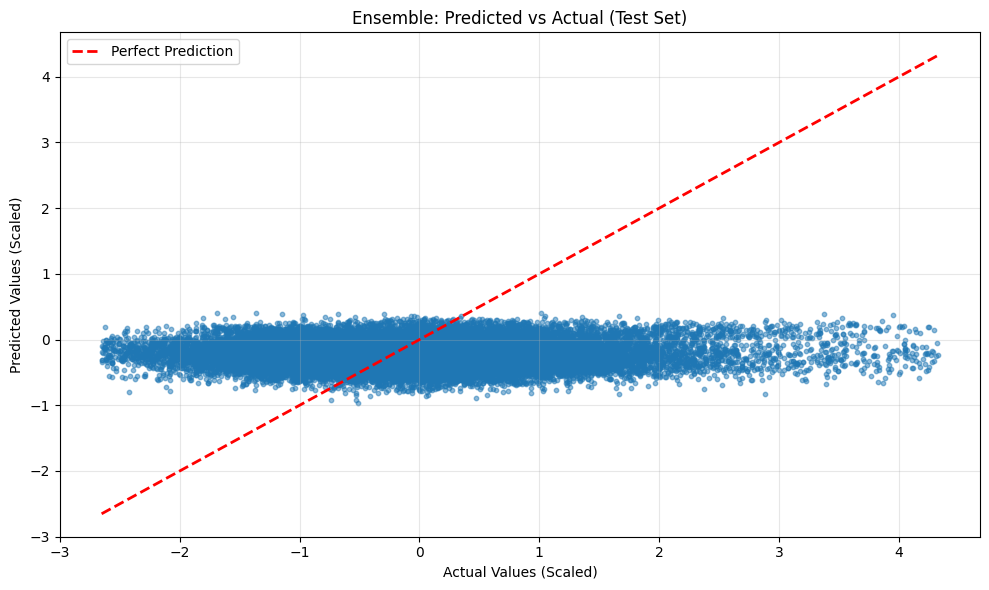

In [38]:
# Visualize: Predicted vs Actual
if ensemble_pred_scaled is not None:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_seq, ensemble_pred_scaled, alpha=0.5, s=10)
    plt.plot([y_test_seq.min(), y_test_seq.max()], 
             [y_test_seq.min(), y_test_seq.max()], 
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values (Scaled)')
    plt.ylabel('Predicted Values (Scaled)')
    plt.title('Ensemble: Predicted vs Actual (Test Set)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

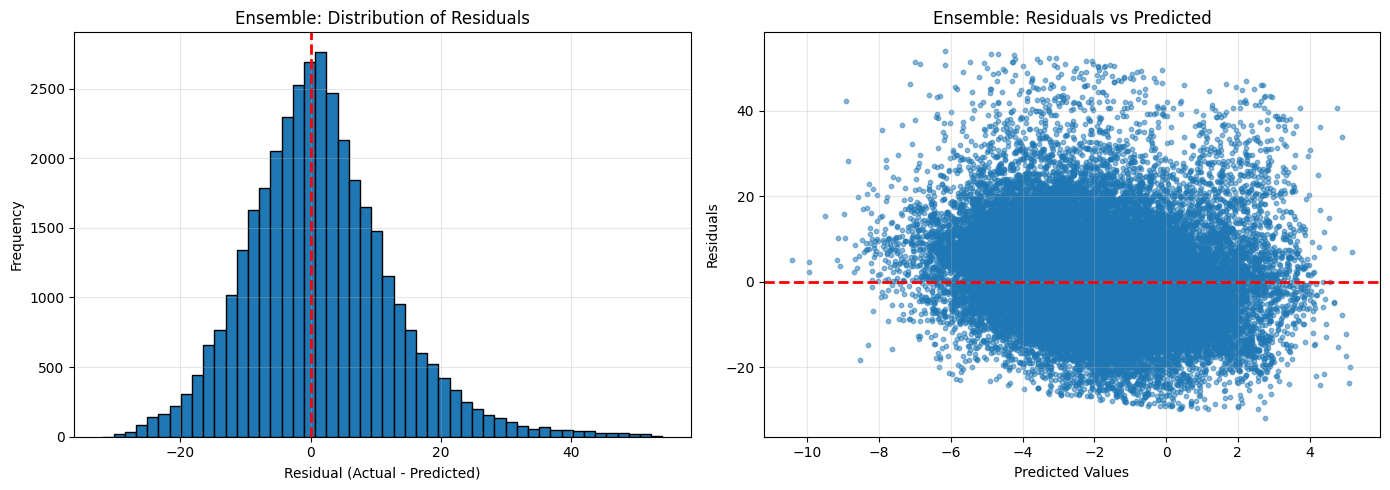

Residual Stats:
   Mean: 1.4679
   Std:  11.1068
   Min:  -31.9995
   Max:  54.0900


In [39]:
# Visualize: Residuals Analysis
if ensemble_pred_scaled is not None:
    residuals = y_test_original - ensemble_pred_original
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Residuals histogram
    axes[0].hist(residuals, bins=50, edgecolor='black')
    axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Residual (Actual - Predicted)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Ensemble: Distribution of Residuals')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals vs Predicted
    axes[1].scatter(ensemble_pred_original, residuals, alpha=0.5, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Ensemble: Residuals vs Predicted')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Residual Stats:")
    print(f"   Mean: {residuals.mean():.4f}")
    print(f"   Std:  {residuals.std():.4f}")
    print(f"   Min:  {residuals.min():.4f}")
    print(f"   Max:  {residuals.max():.4f}")

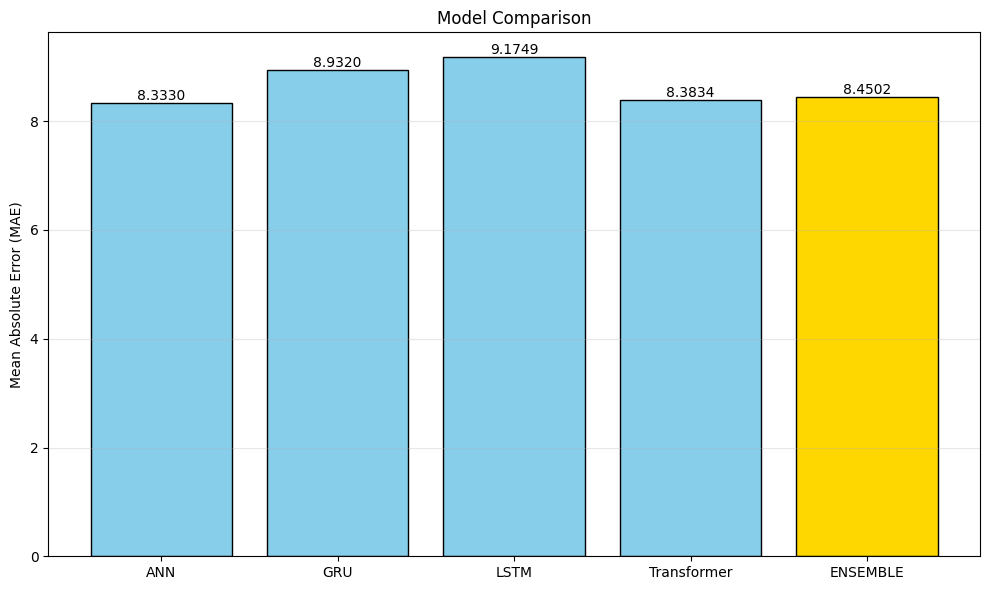

In [41]:
# Visualize: Model Comparison
if ensemble_pred_scaled is not None:
    # Collect MAE values
    mae_values = []
    labels = []
    
    if pred_ann_aligned is not None:
        mae_values.append(mae_ann)
        labels.append('ANN')
    
    if pred_gru_scaled is not None:
        mae_values.append(mae_gru)
        labels.append('GRU')
    
    if pred_lstm_scaled is not None:
        mae_values.append(mae_lstm)
        labels.append('LSTM')
    
    if pred_transformer_scaled is not None:
        mae_values.append(mae_transformer)
        labels.append('Transformer')
    
    mae_values.append(mae)
    labels.append('ENSEMBLE')
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    colors = ['skyblue'] * (len(labels) - 1) + ['gold']
    bars = plt.bar(labels, mae_values, color=colors, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()